In [8]:
import torch
import matplotlib.pyplot as plt

# Define time steps
T = 3  # Example 3 time periods
device = (
    torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
)  # Use "cuda" if available

# Initialize decision variables as trainable parameters
P11 = torch.rand(T, requires_grad=True, device=device)
P12 = torch.rand(T, requires_grad=True, device=device)
P21 = torch.rand(T, requires_grad=True, device=device)
P22 = torch.rand(T, requires_grad=True, device=device)
U1 = torch.rand(T, requires_grad=True, device=device)
U2 = torch.rand(T, requires_grad=True, device=device)

# Constants (example values)
P1T = torch.tensor([100, 120, 110], dtype=torch.float, device=device)
P2T = torch.tensor([90, 80, 100], dtype=torch.float, device=device)
PD1 = torch.tensor([80, 100, 90], dtype=torch.float, device=device)
PD2 = torch.tensor([70, 60, 100], dtype=torch.float, device=device)

L_d11, L_d12, L_d21, L_d22 = 0.95, 0.90, 0.92, 0.93  # Loss factors
k1 = torch.tensor([1.0, 1.1, 1.2], dtype=torch.float, device=device)
k2 = torch.tensor([1.3, 1.2, 1.0], dtype=torch.float, device=device)
E1 = torch.tensor([10, 10, 10], dtype=torch.float, device=device)
E2 = torch.tensor([10, 10, 10], dtype=torch.float, device=device)

# Hyperparameters for constraint penalties
λ_s = 100  # Supply penalty
λ_d = 100  # Demand penalty
λ_n = 100  # Non-negativity penalty

# Define optimizer
optimizer = torch.optim.Adam([P11, P12, P21, P22, U1, U2], lr=0.01)

losses = []

# Gradient Descent Loop
for epoch in range(5000):
    optimizer.zero_grad()

    # Cost function
    J = torch.sum(k1 * (P11 + P12) + k2 * (P21 + P22) + E1 * U1 + E2 * U2)

    # Supply constraint penalties
    L_supply = λ_s * torch.sum(
        torch.relu(P11 + P12 - P1T) ** 2 + torch.relu(P21 + P22 - P2T) ** 2
    )

    # Demand constraint penalties
    L_demand = λ_d * torch.sum(
        (P11 * L_d11 + P21 * L_d21 + U1 - PD1) ** 2
        + (P12 * L_d12 + P22 * L_d22 + U2 - PD2) ** 2
    )

    # Non-negativity penalty
    L_neg = λ_n * torch.sum(
        torch.relu(-P11) ** 2
        + torch.relu(-P12) ** 2
        + torch.relu(-P21) ** 2
        + torch.relu(-P22) ** 2
        + torch.relu(-U1) ** 2
        + torch.relu(-U2) ** 2
    )

    # Total loss
    L_total = J + L_supply + L_demand + L_neg
    losses.append(L_total.item())
    # Compute gradients and update
    L_total.backward()
    optimizer.step()

    # Print every 500 iterations
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {L_total.item()}")

# Print final results
print("\nOptimized Power Dispatch:")
print(f"P11: {P11.detach().cpu().numpy()}")
print(f"P12: {P12.detach().cpu().numpy()}")
print(f"P21: {P21.detach().cpu().numpy()}")
print(f"P22: {P22.detach().cpu().numpy()}")
print(f"U1:  {U1.detach().cpu().numpy()}")
print(f"U2:  {U2.detach().cpu().numpy()}")

Epoch 0, Loss: 4164105.75
Epoch 500, Loss: 2929424.25
Epoch 1000, Loss: 1995133.125
Epoch 1500, Loss: 1305299.25
Epoch 2000, Loss: 812597.125
Epoch 2500, Loss: 475792.5625
Epoch 3000, Loss: 258221.875
Epoch 3500, Loss: 127498.65625
Epoch 4000, Loss: 56037.51953125
Epoch 4500, Loss: 21635.822265625

Optimized Power Dispatch:
P11: [27.921888 32.86877  30.196726]
P12: [24.336533 21.285154 33.753845]
P21: [27.621487 33.46659  30.404444]
P22: [25.076979 21.579767 33.205254]
U1:  [27.236044 33.212757 31.008867]
U2:  [24.539438 20.731775 33.49969 ]


Text(0.5, 1.0, 'Loss vs Epoch')

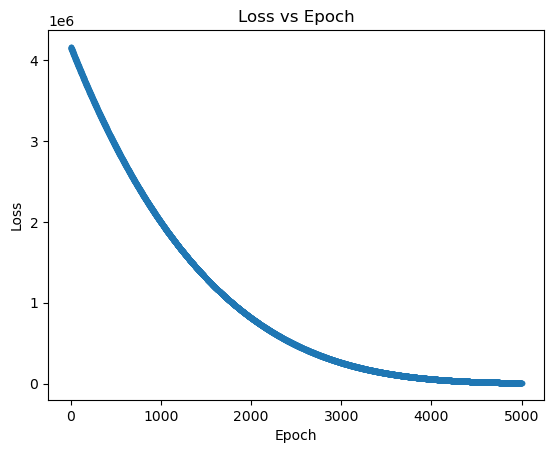

In [9]:
plt.plot(losses, ".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")